In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
import pickle
with open('xgb_name_matcher.pkl', 'rb') as f:
    xgb_name_matcher = pickle.load(f)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from helper import get_results, hist_plot
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('data/Mathwizzathon_Entity_Matching_Dataset.xlsx')
df_val = pd.read_csv('data/df_val.csv', index_col=[0])

In [3]:
df[['prediction', 'proba']] = xgb_name_matcher.predict_using_pandas_dataframe(df, 'Name1', 'Name2', require_proba=True, apply_control_mechanism=False)

Preprocessing started.


100%|█████████████████████████████████████████████████████████████████████████████| 3384/3384 [00:23<00:00, 144.34it/s]


Preprocessing completed. Feature Generation in progress...


100%|███████████████████████████████████████████████████████████████████████████| 3384/3384 [00:00<00:00, 39123.58it/s]

Feature generation completed.


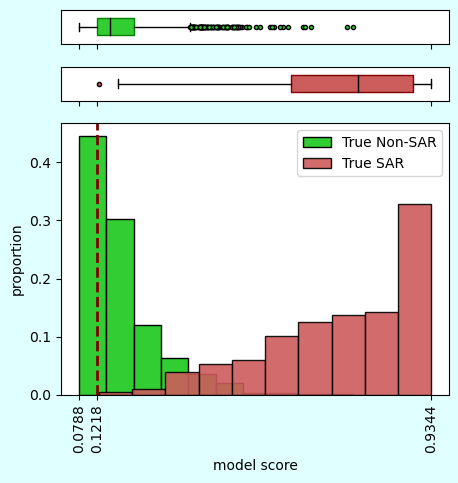

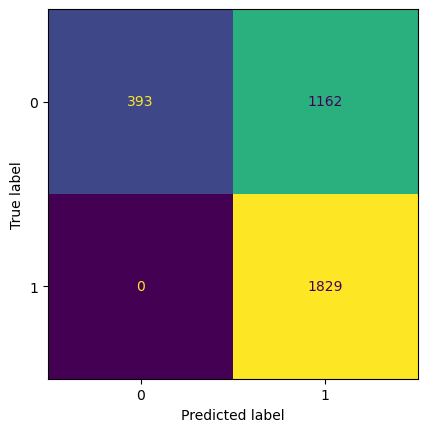

In [5]:
get_results(df['Label'], df['proba'], threshold=xgb_name_matcher.threshold)

In [6]:
print(f"f1 score = {f1_score(df['Label'], df['prediction'])},\n\
accuracy score = {accuracy_score(df['Label'], df['prediction'])},\n\
precision score = {precision_score(df['Label'], df['prediction'])},\n\
recall score = {recall_score(df['Label'], df['prediction'])}")

f1 score = 0.7589211618257262,
accuracy score = 0.6566193853427896,
precision score = 0.6115011701771983,
recall score = 1.0


### Results Analysis

In [7]:
df['score_bucket'] = pd.cut(df['proba'], bins=np.arange(0.1, 1.1, 0.1), labels=[f"{i:.1f}-{i+0.1:.1f}" for i in np.arange(0.1, 1, 0.1)])
df['name1_length'] = df['Name1'].str.len()
df['name1_length_bucket'] = pd.cut(df['name1_length'], bins=np.arange(0, 71, 10), labels=[f"{i+1:d}-{i+10:d}" for i in np.arange(0, 70, 10)])

In [15]:
# score vs length
table = pd.pivot_table(df[df['Label']==1], values='Name1', index='name1_length_bucket', columns='score_bucket', aggfunc='count')

In [16]:
table.to_csv('output/xgb_score_vs_length_test.csv')

### Data Drift

In [9]:
def compute_psi(df_val, df, col):
    """Compute PSI for columns between df_train_month and df_prod_month"""
    breakpoints = pd.qcut(
        df_val[col].astype(float), q=10, retbins=True, duplicates="drop"
    )[1]
    expected_frac = np.histogram(df_val[col].astype(float), breakpoints)[0] / len(
        df_val
    )
    actual_frac = np.histogram(df[col].astype(float), breakpoints)[0] / len(
        df
    )
    expected_frac = np.clip(expected_frac, a_min=1e-8, a_max=None)
    actual_frac = np.clip(actual_frac, a_min=1e-8, a_max=None)
    psi = np.sum(
        (actual_frac - expected_frac) * np.log(actual_frac / expected_frac)
    )
    return psi

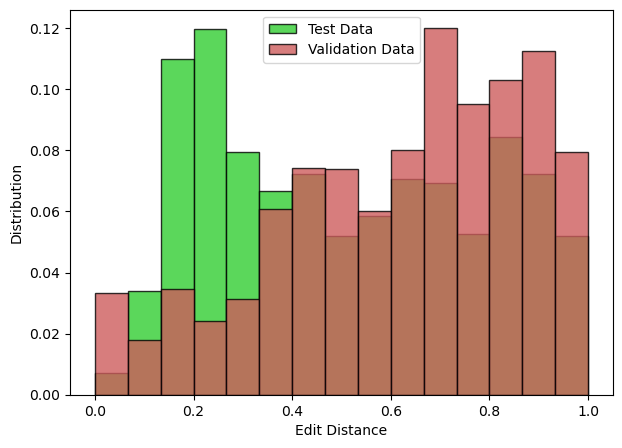

In [12]:
bins=15
fig, ax = plt.subplots(figsize=(7,5))
df['levenshtein'] = df[['Name1', 'Name2']].apply(lambda vec: xgb_name_matcher.levenshtein(vec[0], vec[1]), axis=1)
hist_plot(df[df['Label']==1]['levenshtein'], bins, ax, 'Test Data', 'limegreen', alpha=0.8)
hist_plot(df_val[df_val['label']==1]['levenshtein'], bins, ax, 'Validation Data', 'indianred', alpha=0.8)
plt.xlabel('Edit Distance')
plt.ylabel('Distribution')
plt.legend()
plt.show()